<a href="https://colab.research.google.com/github/LuisEduardoRB/EDP-II/blob/main/Inventario_%C3%93ptimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inventario óptimo

Se estudia un modelo de inventario con **descuento por cantidad**.  
El costo total anual tiene la forma clásica de EOQ, pero con dos regiones:

- Región 1 (sin descuento): $Q<q$, costo unitario $c_1$.
- Región 2 (con descuento): $Q\ge q$, costo unitario $c_2<c_1$.

El objetivo es:

1. (Ejercicio 1) Construir una función que calcule la cantidad óptima $Q_\text{opt}$:
   - Resuelve internamente la ecuación cuadrática de intersección.
   - Selecciona la solución correcta.
   - Indica en qué región (1 o 2) se encuentra.
2. (Ejercicio 2) Con esa $Q_\text{opt}$, determinar la **política óptima**:
   - Cantidad a ordenar $Q_\text{opt}$.
   - Punto de reorden $w$.



## Bloque 1: imports y datos

En este bloque se importan las librerías:

- `sympy` para manipulación simbólica (ecuación cuadrática).
- `numpy` para cálculo numérico.
- `matplotlib` para graficar el costo total.

También se fijan los parámetros del problema: costos, demanda $d$, costo de mantener inventario $h$, costo de ordenar $k$, lead time $L$ y punto de quiebre $q$ del descuento.


In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema
c1=3      # costo unitario antes del descuento
c2=2.5    # costo unitario después del descuento
d=187.5   # demanda anual
h=0.02    # costo de mantener inventario
k=20      # costo de ordenar
L=2       # tiempo de entrega
q=1000    # punto de quiebre del descuento


## Bloque 2 – Ejercicio 1: función `Qoptima`

La función `Qoptima` hace tres cosas principales:

1. Calcula el **EOQ clásico**:
   $$Q^*=\sqrt{\frac{2kd}{h}},$$
   que minimiza el costo cuando no hay descuento.

2. Calcula el costo de la región 1 en $Q^*$:
$$
T_1(Q^*) = c_1 d + \frac{k d}{Q^*} + \frac{h Q^*}{2}.
$$

3. Construye la ecuación cuadrática de intersección entre la curva de la región 2 y la línea de nivel $T_1(Q^*)$.

Primero definimos el costo en la región 2:
$$
T_2(Q) = c_2 d + \frac{k d}{Q} + \frac{hQ}{2}.
$$

La intersección se da cuando
$$
T_2(Q) = T_1(Q^*).
$$

Es decir,
$$
c_2 d + \frac{k d}{Q} + \frac{hQ}{2} = T_1(Q^*).
$$

Multiplicando por $2Q$ y pasando todo al mismo lado se obtiene la ecuación cuadrática:
$$
h Q^2 + (2 c_2 d - 2 T_1(Q^*)) Q + 2 k d = 0.
$$

Esta es la ecuación que se resuelve con `sympy.solve`.


- Si $Q^*\ge q$, la solución óptima está en la **región 2**, y se toma $Q_\text{opt}=Q^*$.
- Si $Q^*<q$, se comparan los costos:
  - $$T_1(Q^*)$$ en región 1.
  - $T_2(q)$ en la región 2 (el mejor punto factible en esa región).
  Se escoge la región con menor costo:
  - Si $T_1(Q^*)\le T_2(q)$, se queda en región 1 con $Q_\text{opt}=Q^*$.
  - Si $T_1(Q^*)>T_2(q)$, conviene el descuento, y se toma $Q_\text{opt}=q$ (región 2).

La función devuelve $Q_\text{opt}$ y un texto que indica la región.

In [3]:
def Qoptima(c1,c2,d,h,k,q,info=True):
    """
    Calcula la Q óptima con descuento por cantidad.
    - Resuelve internamente la ecuación cuadrática de intersección.
    - Selecciona la solución correcta.
    - Indica en qué región está (antes o después del descuento).
    """
    # EOQ clásico (no depende del costo unitario en la derivada)
    Q_star=np.sqrt(2*k*d/h)

    # Costo mínimo en región 1 evaluado en Q*
    T1_Qstar=c1*d+(k*d/Q_star)+(h*Q_star/2)

    # Ecuación cuadrática de intersección T2(Q)=T1(Q*)
    # T2(Q)=c2*d+(k*d/Q)+(h*Q/2)
    # => h*Q^2+(2*c2*d-2*T1(Q*))*Q+2*k*d=0
    Q=sp.symbols('Q',real=True)
    B=(2*c2*d-2*T1_Qstar)
    C=2*k*d
    eq=sp.Eq(h*Q**2+B*Q+C,0)

    roots=sp.solve(eq,Q)
    roots_num=[float(r) for r in roots]
    roots_pos=[r for r in roots_num if r>0]

    # Decisión de región usando comparación de costos
    if Q_star>=q:
        region="Región 2 (con descuento)"
        Q_opt=Q_star
    else:
        T2_q=c2*d+(k*d/q)+(h*q/2)
        if T1_Qstar<=T2_q:
            region="Región 1 (sin descuento)"
            Q_opt=Q_star
        else:
            region="Región 2 (con descuento)"
            Q_opt=q

    if info:
        print("EOQ clásico Q* =",Q_star)
        print("Ecuación cuadrática de intersección: h*Q^2+(",B,")*Q+",C,"=0")
        print("Raíces:",roots_num)
        print("Raíces positivas:",roots_pos)
        print("Q óptima =",Q_opt)
        print("La solución está en:",region)

    return Q_opt,region


## Bloque 3 – Ejercicio 2: función `politica_optima`

La función `politica_optima` recibe los datos del problema y:

1. Llama a `Qoptima` para obtener $Q_\text{opt}$ y la región.
2. Calcula el **tiempo entre órdenes**:
   $$
   t^*=\frac{Q_\text{opt}}{d}.
   $$
3. Determina cuántos ciclos completos caben en el lead time $L$:
   $$
   n=\lfloor L/t^*\rfloor.
   $$
4. Calcula el **tiempo de entrega efectivo**:
   $$
   L_e=L-n\,t^*.
   $$
5. Obtiene el **punto de reorden**:
   $$
   w=L_e\,d.
  $$

La función imprime (si `info=True`) y devuelve $Q_\text{opt}$, $w$ y la región en la que se encuentra la solución.


In [4]:
def politica_optima(c1,c2,d,h,k,L,q,info=True):
    """
    Recibe los datos del problema y devuelve:
    - Q_opt: cantidad óptima a ordenar.
    - w: punto de reorden.
    - region: región en la que está la solución.
    """
    Q_opt,region=Qoptima(c1,c2,d,h,k,q,info=False)

    # Tiempo entre órdenes
    t_star=Q_opt/d

    # Ciclos completos durante el tiempo de entrega
    n=np.floor(L/t_star)

    # tiempo de entrega efectivo
    L_e=L-n*t_star

    # Punto de reorden
    w=L_e*d

    if info:
        print("\n--- Política óptima de inventario ---")
        print("Q_opt =",Q_opt)
        print("Región:",region)
        print("t* (tiempo entre órdenes) =",t_star)
        print("n ciclos completos durante L:",n)
        print("Tiempo de entrega efectivo L_e =",L_e)
        print("Punto de reorden w =",w,"unidades")

    return Q_opt,w,region


## Bloque 4 – Ejecución con los datos del problema

En este bloque se llaman explícitamente:

- `Qoptima(...)` para resolver el Ejercicio 1.
- `politica_optima(...)` para resolver el Ejercicio 2 y obtener la política óptima de inventario para los parámetros dados.


In [5]:
Q_opt,region=Qoptima(c1,c2,d,h,k,q,info=True)
Q_opt,w,region=politica_optima(c1,c2,d,h,k,L,q,info=True)


EOQ clásico Q* = 612.3724356957945
Ecuación cuadrática de intersección: h*Q^2+( -211.9948974278318 )*Q+ 7500.0 =0
Raíces: [35.497084844748485, 10564.247786546852]
Raíces positivas: [35.497084844748485, 10564.247786546852]
Q óptima = 1000
La solución está en: Región 2 (con descuento)

--- Política óptima de inventario ---
Q_opt = 1000
Región: Región 2 (con descuento)
t* (tiempo entre órdenes) = 5.333333333333333
n ciclos completos durante L: 0.0
Tiempo de entrega efectivo L_e = 2.0
Punto de reorden w = 375.0 unidades


## Bloque 5 – Gráfica del costo total

Finalmente se define la función de costo total:

$$
T(Q)=
\begin{cases}
c_1 d + \dfrac{k d}{Q} + \dfrac{hQ}{2}, & Q < q, \\[6pt]
c_2 d + \dfrac{k d}{Q} + \dfrac{hQ}{2}, & Q \ge q.
\end{cases}
$$

y se grafica en un rango de $Q$.

En la gráfica se marcan:

- La línea vertical en $Q = q$ (punto de quiebre del descuento).  
- La línea vertical en $Q = Q_{\text{opt}}$ (solución óptima).

Esto permite visualizar en qué región cae la solución y cómo se comporta el costo total alrededor de ella, igual que cuando se comparan soluciones numéricas en problemas de EDP y se analiza el mínimo del funcional de energía.


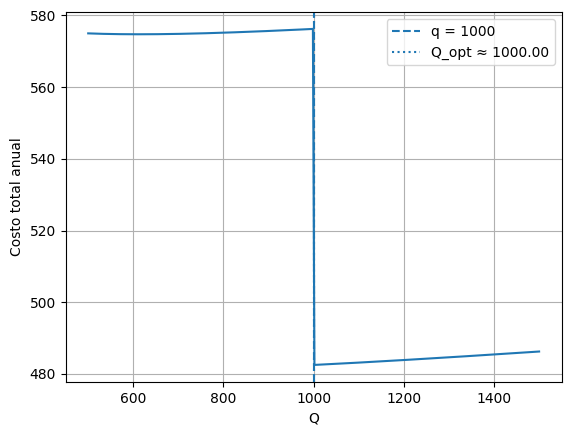

In [6]:
def T(Q,c1,h,k,d,c2,q):
    return np.where(
        Q<q,
        c1*d+(k*d/Q)+(h*Q/2),
        c2*d+(k*d/Q)+(h*Q/2)
    )

x=np.linspace(500,1500,300)
plt.plot(x,T(x,c1,h,k,d,c2,q))
plt.axvline(q,linestyle='--',label="q = "+str(q))
plt.axvline(Q_opt,linestyle=':',label=f"Q_opt ≈ {Q_opt:.2f}")
plt.xlabel("Q")
plt.ylabel("Costo total anual")
plt.grid(True)
plt.legend()
plt.show()


# El código a continuación es el que se realizó en clase y sobre el cual me basé para realizar el anterior.

Q* = 612.3724356957945


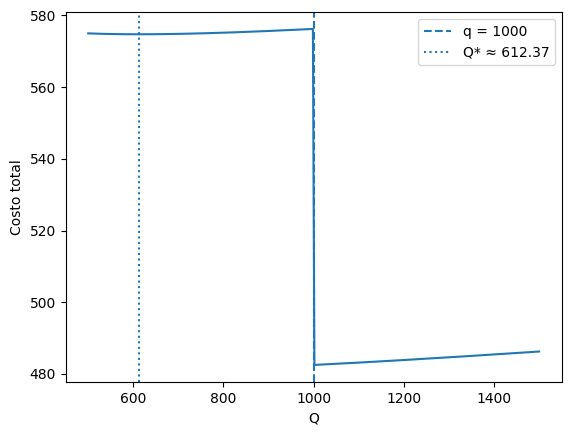

Ecuación simbólica:
Eq(Q1**2 + 2*Q1*(c2*d - g)/h + 2*d*k/h, 0)
Ecuación ya con constantes:
Eq(1.0*Q1**2 - 10599.7448713916*Q1, -375000.0)
Soluciones exactas:
[35.4970848447485, 10564.2477865469]
Soluciones numéricas:
[35.4970848447485, 10564.2477865469]
La política de inventario es pedir:  10564.2477865469  cada que el nivel de inventario baje a:  375.0  unidades


In [7]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np

c1 = 3      # costo unitario antes del descuento
c2 = 2.5    # costo unitario después del descuento
d = 187.5   # demanda anual
h = 0.02    # costo de mantener inventario
k = 20      # costo de ordenar
L = 2       # no lo usas aquí, pero lo dejo
q = 1000    # punto de quiebre del descuento

# Paso 1. Calculamos Q*
def Qop(k, d, h):
    return np.sqrt((2 * k * d) / h)

g = Qop(k, d, h)   # Q* numérico
print("Q* =", g)

# Costo con c1 evaluado en Q* (T1(Q*))
T1_Qstar = c1*d + (k*d/g) + (h*g/2)

# Función de costo total con salto en Q = q
def T(Q, c1, h, k, d, c2, q):
    return np.where(
        Q < q,
        c1 * d + (k * d / Q) + (h * Q / 2),
        c2 * d + (k * d / Q) + (h * Q / 2)
    )

# Gráfica
x = np.linspace(500, 1500, 300)   # amplio el rango para ver bien el salto
plt.plot(x, T(x, c1, h, k, d, c2, q))
plt.axvline(q, linestyle='--', label="q = 1000")
plt.axvline(g, linestyle=':', label=f"Q* ≈ {g:.2f}")
plt.xlabel("Q")
plt.ylabel("Costo total")
plt.legend()
plt.show()

# --------------------- SYMPY ---------------------

# incógnita
Q1 = sp.symbols('Q1')

# parámetros simbólicos (separados de los numéricos)
c2_s, d_s, h_s, k_s, g_s = sp.symbols('c2 d h k g')

# ecuación: Q1^2 + (2/h)*(c2*d - T1(Q*)) * Q1 + 2*k*d/h = 0
eq = sp.Eq(Q1**2 + (2/h_s)*(c2_s*d_s - g_s)*Q1 + 2*k_s*d_s/h_s, 0)

print("Ecuación simbólica:")
print(eq)

# Sustituimos valores numéricos
valores = {
    c2_s: 2.5,
    d_s: 187.5,
    h_s: 0.02,
    k_s: 20,
    g_s: T1_Qstar     # aquí va T1(Q*), no Q*
}

eq_num = sp.simplify(eq.subs(valores))
print("Ecuación ya con constantes:")
print(eq_num)

# Resolver para Q1
sol = sp.solve(eq_num, Q1)
print("Soluciones exactas:")
print(sol)

# Aproximaciones numéricas
sol_num = [s.evalf() for s in sol]
print("Soluciones numéricas:")
print(sol_num)
solucion=sol_num[1]


#Caculamos los valores t* y L_e para determinar la política de inventario
ts=T1_Qstar/d
n=np.floor(L/ts)
L_e=L-n*ts
w=L_e*d
print("La política de inventario es pedir: ", solucion, " cada que el nivel de inventario baje a: ", w," unidades")